In [1]:
# --- CELL 1: Local Setup (Mac M1) ---
import sys
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Diffusers imports
from diffusers import UNet2DModel, DDPMScheduler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# 1. Setup Paths
# Add '../src' to the python path so we can import our modules
sys.path.append(os.path.abspath('../src'))

# 2. Verify Imports
try:
    from dataset import TriModalDataset
    print("Success: 'src' module loaded.")
except ImportError as e:
    print(f"Error: Could not import from src. {e}")

# 3. Setup Device (Use Metal Performance Shaders for M1)
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Training on: Apple M1 GPU (MPS)")
else:
    DEVICE = torch.device("cpu")
    print("Training on: CPU (Warning: Slow)")

# 4. Define Local Data Paths
PARQUET_PATH = '../data/processed/OAI_model_ready_data.parquet'
IMAGE_ROOT = '../data/sandbox'

/Users/abhi/Downloads/M.tech/Sem 3/Major Project/oa-survival-model/.venv/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Success: 'src' module loaded.
Training on: Apple M1 GPU (MPS)


In [2]:
# --- CELL 2: Semantic Encoder Architecture ---

class SemanticEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Use ResNet18 backbone
        # We use default weights=None for local test to avoid download issues, 
        # or weights='DEFAULT' if internet is fine.
        try:
            resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        except:
            resnet = models.resnet18(weights=None)
            
        # Remove the final FC layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        # Add a projection to our desired latent dimension
        self.projection = nn.Linear(512, latent_dim)
    
    def forward(self, x):
        # x: [Batch, 3, 64, 64]
        x = self.features(x)       # -> [Batch, 512, 1, 1]
        x = x.view(x.size(0), -1)  # -> [Batch, 512]
        z = self.projection(x)     # -> [Batch, 128]
        return z

print("Semantic Encoder Class defined.")

Semantic Encoder Class defined.


In [3]:
# --- CELL 3: Initialize Diffusion Components ---

# 1. The Noise Scheduler
scheduler = DDPMScheduler(num_train_timesteps=1000)

# 2. The UNet (Generator)
# We keep the same structure
unet = UNet2DModel(
    sample_size=64,  
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256), 
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    class_embed_type="identity" 
).to(DEVICE)

# 3. The Encoder -> CHANGED latent_dim to 256
# The UNet's time embedding is 4 * base_channels (4 * 64 = 256)
# So our encoder must match 256 exactly.
encoder = SemanticEncoder(latent_dim=256).to(DEVICE) 

# 4. Optimizer (Train both)
optimizer = torch.optim.Adam(list(unet.parameters()) + list(encoder.parameters()), lr=1e-4)

print("Diffusion Model & Encoder initialized. Dimensions aligned (256).")

Diffusion Model & Encoder initialized. Dimensions aligned (256).


In [4]:
# --- CELL 4: Data Prep ---

# 1. Transforms for Diffusion (64x64, [-1, 1] range)
train_transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) 
])

# 2. Load Data
df = pd.read_parquet(PARQUET_PATH)

# --- FIX: Apply One-Hot Encoding ---
# The dataset expects 'KL_Grade_1.0', 'Sex_2', etc.
df = pd.get_dummies(df, columns=['KL_Grade', 'Sex'], drop_first=True)

# Ensure all expected columns exist (fill 0 if missing)
expected_cols = ['KL_Grade_1.0', 'KL_Grade_2.0', 'KL_Grade_3.0', 'KL_Grade_4.0', 'Sex_2']
for col in expected_cols:
    if col not in df.columns:
        df[col] = 0
# -----------------------------------

# Just use a small subset for local testing to make it fast
train_df = df.head(100) 

# 3. Create Dataset & Loader
dataset = TriModalDataset(train_df, IMAGE_ROOT, transform=train_transform, mode='sandbox')
loader = DataLoader(dataset, batch_size=8, shuffle=True)

print(f"Data ready. Training on {len(train_df)} samples.")
print(f"Columns available: {train_df.columns.tolist()}") # Verification print

Dataset initialized in SANDBOX mode. Found 9786 images to sample from.
Data ready. Training on 100 samples.
Columns available: ['ID', 'Knee_Side', 'time_to_event', 'event', 'Age', 'BMI', 'WOMAC_Score', 'KL_Grade_1.0', 'KL_Grade_2.0', 'KL_Grade_3.0', 'KL_Grade_4.0', 'Sex_2']


In [9]:
# --- CELL 5: Training Loop ---

EPOCHS = 100 # Just 1 epoch to verify the code works locally

print("Starting Diffusion Training...")

for epoch in range(EPOCHS):
    unet.train()
    encoder.train()
    total_loss = 0
    
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch in progress_bar:
        # Unpack batch (TriModalDataset returns a dict)
        if isinstance(batch, dict):
            images = batch['image'].to(DEVICE) # [Batch, 3, 64, 64]
        else:
            # Fallback if dataset returns tuple
            images = batch[0].to(DEVICE)

        batch_size = images.shape[0]
        
        # A. Encode Image to Semantic Latent z
        z = encoder(images) 
        
        # B. Sample Noise
        noise = torch.randn_like(images)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (batch_size,), device=DEVICE).long()
        
        # C. Add Noise (Forward Diffusion)
        noisy_images = scheduler.add_noise(images, noise, timesteps)
        
        # D. Predict Noise (Reverse Diffusion)
        # We pass 'z' as class_labels to condition the generation
        noise_pred = unet(noisy_images, timestep=timesteps, class_labels=z).sample
        
        # E. Loss
        loss = F.mse_loss(noise_pred, noise)
        
        # F. Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
        
    print(f"Epoch {epoch+1} Average Loss: {total_loss/len(loader):.4f}")

print("Local Training Test Complete.")

Starting Diffusion Training...


Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Average Loss: 0.0264


Epoch 2/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Average Loss: 0.0244


Epoch 3/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Average Loss: 0.0289


Epoch 4/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Average Loss: 0.0262


Epoch 5/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Average Loss: 0.0224


Epoch 6/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6 Average Loss: 0.0283


Epoch 7/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7 Average Loss: 0.0213


Epoch 8/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8 Average Loss: 0.0311


Epoch 9/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9 Average Loss: 0.0210


Epoch 10/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10 Average Loss: 0.0213


Epoch 11/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11 Average Loss: 0.0254


Epoch 12/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12 Average Loss: 0.0233


Epoch 13/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13 Average Loss: 0.0228


Epoch 14/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14 Average Loss: 0.0220


Epoch 15/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15 Average Loss: 0.0187


Epoch 16/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16 Average Loss: 0.0171


Epoch 17/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17 Average Loss: 0.0121


Epoch 18/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18 Average Loss: 0.0147


Epoch 19/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19 Average Loss: 0.0184


Epoch 20/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20 Average Loss: 0.0225


Epoch 21/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21 Average Loss: 0.0297


Epoch 22/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22 Average Loss: 0.0199


Epoch 23/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23 Average Loss: 0.0127


Epoch 24/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24 Average Loss: 0.0152


Epoch 25/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25 Average Loss: 0.0205


Epoch 26/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26 Average Loss: 0.0218


Epoch 27/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27 Average Loss: 0.0241


Epoch 28/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28 Average Loss: 0.0193


Epoch 29/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29 Average Loss: 0.0110


Epoch 30/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30 Average Loss: 0.0196


Epoch 31/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31 Average Loss: 0.0163


Epoch 32/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32 Average Loss: 0.0103


Epoch 33/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33 Average Loss: 0.0136


Epoch 34/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34 Average Loss: 0.0086


Epoch 35/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35 Average Loss: 0.0097


Epoch 36/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36 Average Loss: 0.0125


Epoch 37/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37 Average Loss: 0.0151


Epoch 38/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38 Average Loss: 0.0121


Epoch 39/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39 Average Loss: 0.0140


Epoch 40/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40 Average Loss: 0.0192


Epoch 41/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41 Average Loss: 0.0173


Epoch 42/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42 Average Loss: 0.0196


Epoch 43/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43 Average Loss: 0.0095


Epoch 44/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44 Average Loss: 0.0105


Epoch 45/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45 Average Loss: 0.0088


Epoch 46/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46 Average Loss: 0.0222


Epoch 47/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47 Average Loss: 0.0136


Epoch 48/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48 Average Loss: 0.0211


Epoch 49/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49 Average Loss: 0.0141


Epoch 50/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50 Average Loss: 0.0179


Epoch 51/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 51 Average Loss: 0.0097


Epoch 52/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 52 Average Loss: 0.0103


Epoch 53/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 53 Average Loss: 0.0119


Epoch 54/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 54 Average Loss: 0.0086


Epoch 55/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 55 Average Loss: 0.0070


Epoch 56/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 56 Average Loss: 0.0164


Epoch 57/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 57 Average Loss: 0.0090


Epoch 58/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 58 Average Loss: 0.0132


Epoch 59/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 59 Average Loss: 0.0171


Epoch 60/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 60 Average Loss: 0.0114


Epoch 61/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 61 Average Loss: 0.0171


Epoch 62/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 62 Average Loss: 0.0114


Epoch 63/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 63 Average Loss: 0.0076


Epoch 64/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 64 Average Loss: 0.0160


Epoch 65/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 65 Average Loss: 0.0078


Epoch 66/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 66 Average Loss: 0.0123


Epoch 67/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 67 Average Loss: 0.0123


Epoch 68/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 68 Average Loss: 0.0072


Epoch 69/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 69 Average Loss: 0.0127


Epoch 70/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 70 Average Loss: 0.0102


Epoch 71/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 71 Average Loss: 0.0129


Epoch 72/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 72 Average Loss: 0.0180


Epoch 73/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 73 Average Loss: 0.0100


Epoch 74/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 74 Average Loss: 0.0102


Epoch 75/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 75 Average Loss: 0.0121


Epoch 76/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 76 Average Loss: 0.0081


Epoch 77/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 77 Average Loss: 0.0108


Epoch 78/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 78 Average Loss: 0.0070


Epoch 79/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 79 Average Loss: 0.0136


Epoch 80/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 80 Average Loss: 0.0095


Epoch 81/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 81 Average Loss: 0.0149


Epoch 82/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 82 Average Loss: 0.0106


Epoch 83/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 83 Average Loss: 0.0090


Epoch 84/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 84 Average Loss: 0.0067


Epoch 85/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 85 Average Loss: 0.0070


Epoch 86/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 86 Average Loss: 0.0093


Epoch 87/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 87 Average Loss: 0.0084


Epoch 88/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 88 Average Loss: 0.0069


Epoch 89/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 89 Average Loss: 0.0074


Epoch 90/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 90 Average Loss: 0.0069


Epoch 91/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 91 Average Loss: 0.0147


Epoch 92/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 92 Average Loss: 0.0084


Epoch 93/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 93 Average Loss: 0.0077


Epoch 94/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 94 Average Loss: 0.0145


Epoch 95/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 95 Average Loss: 0.0111


Epoch 96/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 96 Average Loss: 0.0145


Epoch 97/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 97 Average Loss: 0.0111


Epoch 98/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 98 Average Loss: 0.0067


Epoch 99/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 99 Average Loss: 0.0078


Epoch 100/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 100 Average Loss: 0.0085
Local Training Test Complete.


Generating sample (this might take a minute on M1)...


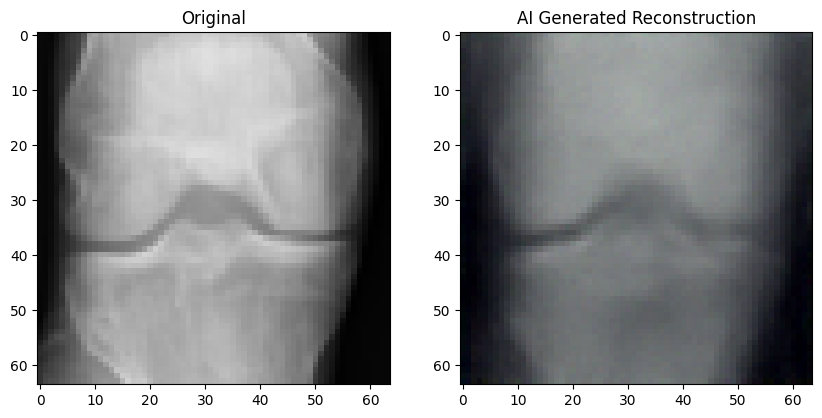

In [10]:
# --- CELL 6: Generation Test ---

def generate_sample(original_image):
    unet.eval()
    encoder.eval()
    
    with torch.no_grad():
        original_image = original_image.unsqueeze(0).to(DEVICE)
        z = encoder(original_image)
        
        # Start from random noise
        generated_image = torch.randn_like(original_image)
        
        # Denoise loop
        for t in scheduler.timesteps:
            model_output = unet(generated_image, t, class_labels=z).sample
            generated_image = scheduler.step(model_output, t, generated_image).prev_sample

    return generated_image.cpu().squeeze()

# Get one sample
sample_data = dataset[0]
if isinstance(sample_data, dict):
    sample_img = sample_data['image']
else:
    sample_img = sample_data[0]

print("Generating sample (this might take a minute on M1)...")
gen_img = generate_sample(sample_img)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample_img.permute(1, 2, 0) * 0.5 + 0.5)
axs[0].set_title("Original")
axs[1].imshow(gen_img.permute(1, 2, 0) * 0.5 + 0.5)
axs[1].set_title("AI Generated Reconstruction")
plt.show()